In [1]:
import os
import time
import cv2
from PIL import Image
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
os.environ["TFHUB_DOWNLOAD_PROGRESS"] = "True"

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

In [3]:
IMAGE_PATH = "/content/Original.jpg"

In [4]:
SAVED_MODEL_PATH = "https://tfhub.dev/captain-pool/esrgan-tf2/1"

In [5]:
def preprocess_image(image_path):
  """ Loads image from path and preprocesses to make it model ready
      Args:
        image_path: Path to the image file
  """
  hr_image = tf.image.decode_image(tf.io.read_file(image_path))
  # If PNG, remove the alpha channel. The model only supports
  # images with 3 color channels.
  if hr_image.shape[-1] == 4:
    hr_image = hr_image[...,:-1]
  hr_size = (tf.convert_to_tensor(hr_image.shape[:-1]) // 4) * 4
  hr_image = tf.image.crop_to_bounding_box(hr_image, 0, 0, hr_size[0], hr_size[1])
  hr_image = tf.cast(hr_image, tf.float32)
  return tf.expand_dims(hr_image, 0)


In [6]:
def save_image(image, filename):
  """
    Saves unscaled Tensor Images.
    Args:
      image: 3D image tensor. [height, width, channels]
      filename: Name of the file to save.
  """
  if not isinstance(image, Image.Image):
    image = tf.clip_by_value(image, 0, 255)
    image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  image.save("%s.jpg" % filename)
  print("Saved as %s.jpg" % filename)

In [7]:
%matplotlib inline
# Declaring the user-defined function for the ploting the image

def plot_image(image, title=""):
  """
    Plots images from image tensors.
    Args:
      image: 3D image tensor. [height, width, channels].
      title: Title to display in the plot.
  """
  image = np.asarray(image)
  image = tf.clip_by_value(image, 0, 255)
  image = Image.fromarray(tf.cast(image, tf.uint8).numpy())
  plt.imshow(image)
  plt.axis("off")
  plt.title(title)

In [8]:
hr_image = preprocess_image(IMAGE_PATH)

Saved as Original Image.jpg


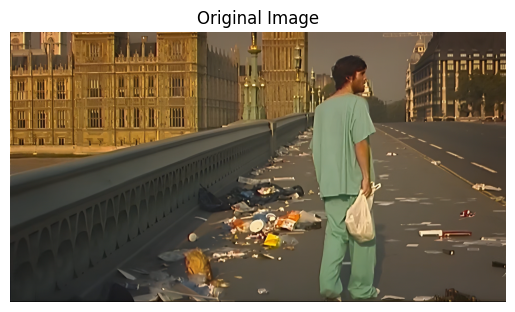

In [9]:
plot_image(tf.squeeze(hr_image), title="Original Image")
save_image(tf.squeeze(hr_image), filename="Original Image")

In [10]:
original_image = cv2.imread("/content/Original.jpg")

In [11]:
original_image.shape

(696, 1280, 3)

In [12]:
model = hub.load(SAVED_MODEL_PATH)

In [13]:
start = time.time()
fake_image = model(hr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 263.041963


Saved as Super Resolution.jpg


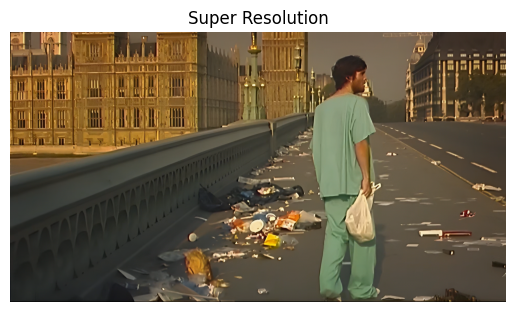

In [14]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
save_image(tf.squeeze(fake_image), filename="Super Resolution")

In [15]:
upscaled_image = cv2.imread('/content/Image.jpg')

In [16]:
upscaled_image.shape

(199, 253, 3)

In [17]:
def unsharp_mask(image, kernel_size=(5, 5), sigma=1.0, amount=1.0, threshold=0):
    """Return a sharpened version of the image, using an unsharp mask."""
    blurred = cv2.GaussianBlur(image, kernel_size, sigma)
    sharpened = float(amount + 1) * image - float(amount) * blurred
    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)
    if threshold > 0:
        low_contrast_mask = np.absolute(image - blurred) < threshold
        np.copyto(sharpened, image, where=low_contrast_mask)
    return sharpened

In [18]:
sharpened_image = unsharp_mask(upscaled_image)

In [19]:
cv2.imwrite('original_final_image.jpg', sharpened_image)

True

In [52]:
IMAGE_PATH = "/content/Test__image.jpg"

In [53]:
test_image=cv2.imread("/content/Test__image.jpg")

In [54]:
test_image.shape

(513, 517, 3)

In [55]:
def downscale_image(image):
  """
      Scales down images using bicubic downsampling.
      Args:
          image: 3D or 4D tensor of preprocessed image
  """
  image_size = []
  if len(image.shape) == 3:
    image_size = [image.shape[1], image.shape[0]]
  else:
    raise ValueError("Dimension mismatch. Can work only on single image.")

  image = tf.squeeze(
      tf.cast(
          tf.clip_by_value(image, 0, 255), tf.uint8))

  lr_image = np.asarray(
    Image.fromarray(image.numpy())
    .resize([image_size[0] // 4, image_size[1] // 4],
              Image.BICUBIC))

  lr_image = tf.expand_dims(lr_image, 0)
  lr_image = tf.cast(lr_image, tf.float32)
  return lr_image

In [56]:
hr_image = preprocess_image(IMAGE_PATH)

In [57]:
lr_image = downscale_image(tf.squeeze(hr_image))

Saved as Low Resolution.jpg


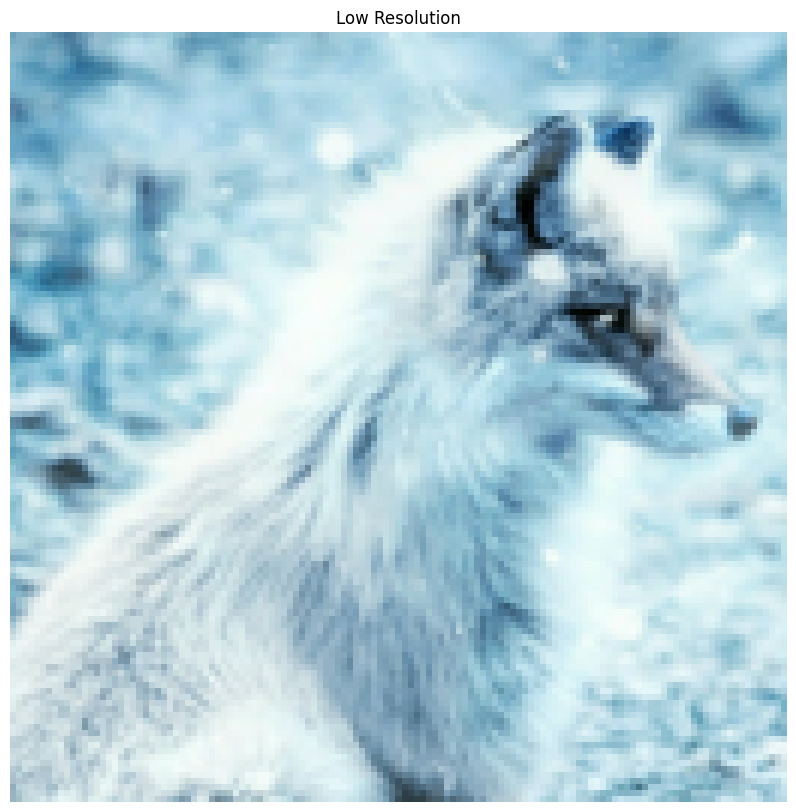

In [58]:
plot_image(tf.squeeze(lr_image), title="Low Resolution")
save_image(tf.squeeze(lr_image), filename="Low Resolution")

In [59]:
test_low_res_image=cv2.imread("/content/Low Resolution.jpg")

In [60]:
test_low_res_image.shape

(128, 129, 3)

In [61]:
model = hub.load(SAVED_MODEL_PATH)

In [62]:
start = time.time()
fake_image = model(lr_image)
fake_image = tf.squeeze(fake_image)
print("Time Taken: %f" % (time.time() - start))

Time Taken: 4.717164


PSNR Achieved: 31.911797
Saved as downscaled Resolution01.jpg


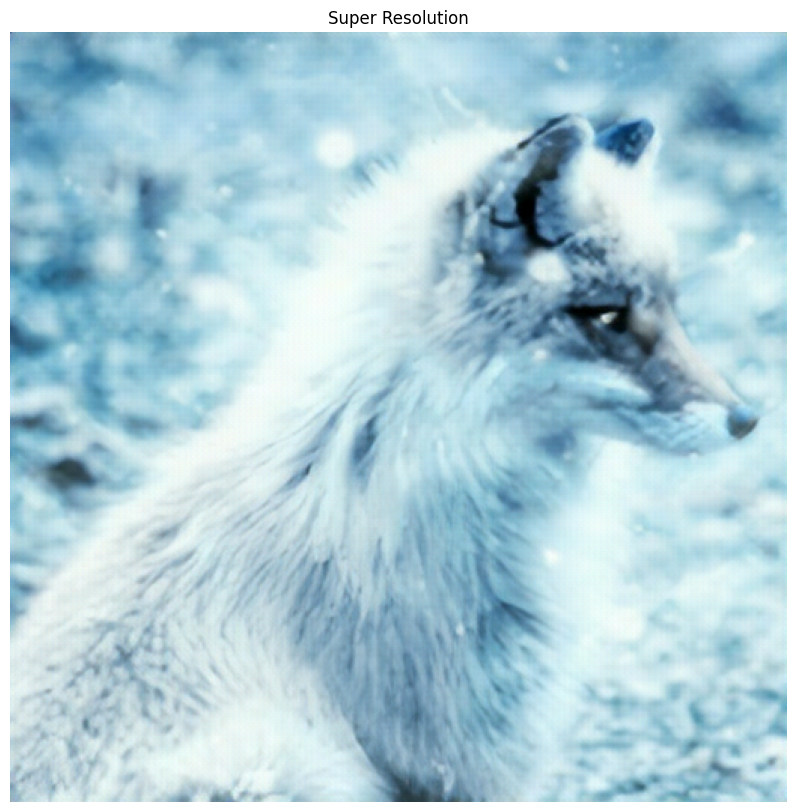

In [63]:
plot_image(tf.squeeze(fake_image), title="Super Resolution")
# Calculating PSNR wrt Original Image
psnr = tf.image.psnr(
    tf.clip_by_value(fake_image, 0, 255),
    tf.clip_by_value(hr_image, 0, 255), max_val=255)
print("PSNR Achieved: %f" % psnr)
save_image(tf.squeeze(fake_image), filename="downscaled Resolution01")

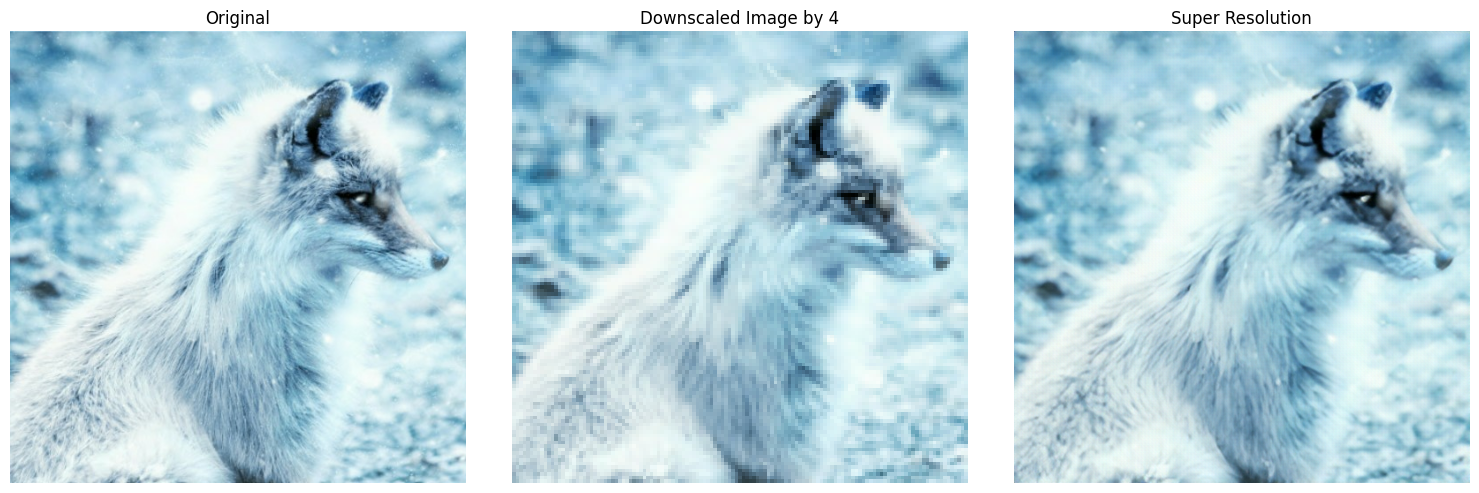

In [64]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axes = plt.subplots(1,3)
fig.tight_layout()
plt.subplot(131)
plot_image(tf.squeeze(hr_image), title="Original")   # Original image

plt.subplot(132)
fig.tight_layout()
# Downscaled test image by resize value as 4
plot_image(tf.squeeze(lr_image), "Downscaled Image by 4")

plt.subplot(133)
fig.tight_layout()
plot_image(tf.squeeze(fake_image), "Super Resolution")  # Super Resolution test image
plt.savefig("ESRGAN_DIV2K.jpg", bbox_inches="tight")


In [65]:
test_upscaled_image=cv2.imread("/content/downscaled Resolution01.jpg")

In [66]:
test_upscaled_image.shape

(512, 516, 3)

In [67]:
sharpened_edge_image = unsharp_mask(test_upscaled_image)

In [68]:
cv2.imwrite('sharpened_edge_image.jpg', sharpened_edge_image)

True

In [69]:
img_path = '/content/sharpened_edge_image.jpg'
img = mpimg.imread(img_path)

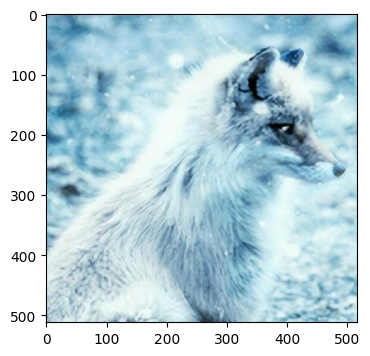

In [70]:
figsize = (6, 4)

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Display the image
imgplot = ax.imshow(img)

# Show the plot
plt.show()

In [71]:
print("PSNR: %f" % psnr)

PSNR: 31.911797
